In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import glob
from scipy import integrate
from sklearn.metrics import mean_squared_error

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

In [2]:
candidate_files = glob.glob('../outputs/files/1510/*.csv')

In [3]:
max_date = pd.to_datetime('2100-01-01')
min_date = pd.to_datetime('1900-01-01')

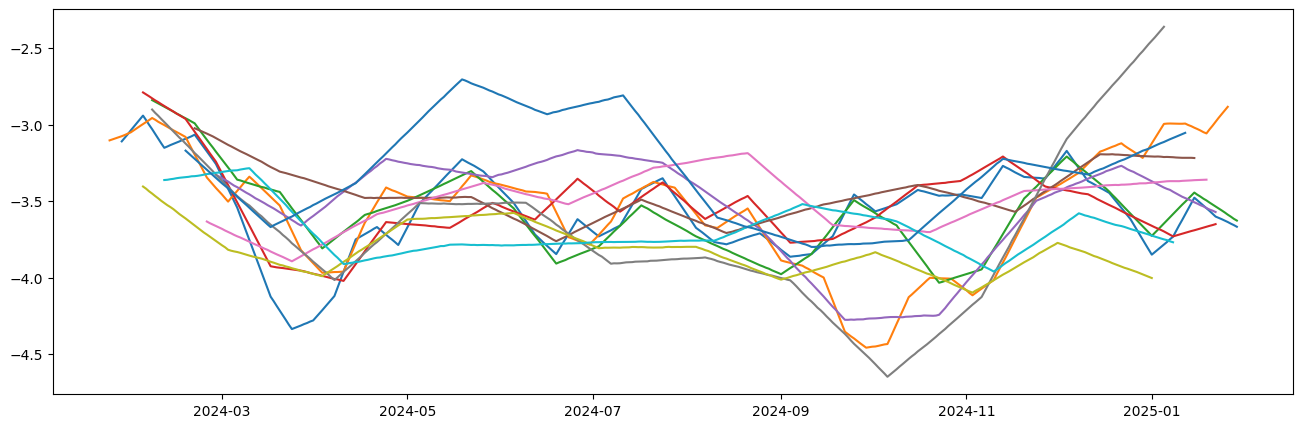

In [4]:
plt.figure(figsize=(16,5))

for file in candidate_files:
    temp = pd.read_csv(file, sep=';')
    temp.dateStart = pd.to_datetime(temp.dateStart)
    temp_min, temp_max = temp.dateStart.tolist()[0], temp.dateStart.tolist()[-1]
    if temp_min >= min_date:
        min_date = temp_min

    if temp_max <= max_date:
        max_date = temp_max

    plt.plot(temp.dateStart.values, temp.muX.values)

In [5]:
reference = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_crAssphages.csv', sep=";")
reference.dateStart = pd.to_datetime(reference.dateStart)

In [6]:
def compute_RMSE(candidate_path, min_date, max_date):
    reference = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_crAssphages.csv', sep=";")
    reference.dateStart = pd.to_datetime(reference.dateStart)

    candidate = pd.read_csv(candidate_path, sep=";")
    candidate.dateStart = pd.to_datetime(candidate.dateStart)

    # restrict to the global min and max so that we dont bias the results anyhow:
    reference = reference.loc[(reference.dateStart>=min_date) & (reference.dateStart<=max_date)]
    candidate = candidate.loc[(candidate.dateStart>=min_date) & (candidate.dateStart<=max_date)]

    this_RMSE = np.sqrt(mean_squared_error(reference.muX.values, candidate.muX.values))
    return this_RMSE

In [7]:
RMSES_weekly = []
RMSES_bimonthly = []
RMSES_monthly = []

for candidate_path in candidate_files[:2]:
    RMSES_weekly.append(compute_RMSE(candidate_path, min_date, max_date))

for candidate_path in candidate_files[2:4]:
    RMSES_bimonthly.append(compute_RMSE(candidate_path, min_date, max_date))

for candidate_path in candidate_files[4:]:
    RMSES_monthly.append(compute_RMSE(candidate_path, min_date, max_date))

In [8]:
def complex_cover_rate_computer(CI1_lower, CI1_upper,
                        CI2_lower, CI2_upper):
    
    # Define the intersection surface :
    upper_border = []
    lower_border = []

    for timestep in range(CI1_upper.shape[0]):
        local_maxs = [CI1_upper[timestep], CI2_upper[timestep]]
        local_mins = [CI1_lower[timestep], CI2_lower[timestep]]

        min_of_maxs = np.min(local_maxs)
        max_of_mins = np.max(local_mins)

        upper_border.append(min_of_maxs)
        lower_border.append(max_of_mins)
        
    # Identify the potential breakpoints :
    no_intersection = []

    for timestep in range(len(upper_border)):
        if upper_border[timestep] < lower_border[timestep]:
            no_intersection.append(timestep) 
            
    if no_intersection==[]:
        print("No breakpoints detected.")
        
        # Compute the different areas
        auc_CI1_upper = integrate.simpson(x=np.arange(CI1_lower.shape[0]), y=CI1_upper)
        auc_CI1_lower = integrate.simpson(x=np.arange(CI1_upper.shape[0]), y=CI1_lower)
        area_CI1 = auc_CI1_upper - auc_CI1_lower

        auc_CI2_upper = integrate.simpson(x=np.arange(CI2_lower.shape[0]), y=CI2_upper)
        auc_CI2_lower = integrate.simpson(x=np.arange(CI2_upper.shape[0]), y=CI2_lower)
        area_CI2 = auc_CI2_upper - auc_CI2_lower

        intersection_area_upper = integrate.simpson(x=np.arange(CI1_lower.shape[0]), y=upper_border)
        intersection_area_lower = integrate.simpson(x=np.arange(CI1_lower.shape[0]), y=lower_border)
        intersection_area = intersection_area_upper - intersection_area_lower

        CR2 = 2*intersection_area / (area_CI1 + area_CI2)
        
    else:        
        step = 1
        breakpoints = []
        breakpoints.append(0)
        breakpoints.append(no_intersection[0])

        for this_index, this_position in enumerate(no_intersection):
            if this_index==len(no_intersection) - 1:
                pass
            else:
                if no_intersection[this_index+1] == this_position + step:
                    continue
                else:
                    breakpoints.append(this_position)
                    breakpoints.append(no_intersection[this_index+1])

        breakpoints.append(no_intersection[-1])
        breakpoints.append(range(CI1_upper.shape[0])[-1]+1)

        # Split the breakpoints into sublists of size 2:
        sublists = []
        start = 0
        end = len(breakpoints) 
        break_step = 2
        for i in range(start, end, break_step): 
            x = i 
            temp = breakpoints[x:x+break_step]

            if i==0:
                pass

            else:
                temp[0]+=1

            sublists.append(temp)

        total_length = CI1_upper.shape[0]
        weights = []
        for element in sublists:
            num = element[-1] - element[0]
            weights.append(num / total_length)

        remaining_proportion = 1 - np.array(weights).sum()

        # Compute the different areas :
        CR_list = []
        intersection_areas = []
        areas_CI1 = []
        areas_CI2 = []

        for element in sublists:    
            auc_CI1_upper = integrate.simpson(x=np.arange(CI1_upper[element[0]:element[-1]].shape[0]), y=CI1_upper[element[0]:element[-1]])
            auc_CI1_lower = integrate.simpson(x=np.arange(CI1_lower[element[0]:element[-1]].shape[0]), y=CI1_lower[element[0]:element[-1]])
            area_CI1 = auc_CI1_upper - auc_CI1_lower

            auc_CI2_upper = integrate.simpson(x=np.arange(CI2_upper[element[0]:element[-1]].shape[0]), y=CI2_upper[element[0]:element[-1]])
            auc_CI2_lower = integrate.simpson(x=np.arange(CI2_lower[element[0]:element[-1]].shape[0]), y=CI2_lower[element[0]:element[-1]])
            area_CI2 = auc_CI2_upper - auc_CI2_lower

            intersection_area_upper = integrate.simpson(x=np.arange(CI1_lower[element[0]:element[-1]].shape[0]), y=upper_border[element[0]:element[-1]])
            intersection_area_lower = integrate.simpson(x=np.arange(CI1_lower[element[0]:element[-1]].shape[0]), y=lower_border[element[0]:element[-1]])
            intersection_area = intersection_area_upper - intersection_area_lower

            intersection_areas.append(intersection_area)
            areas_CI1.append(area_CI1)
            areas_CI2.append(area_CI2)

        intersection_areas = np.array(intersection_areas)
        areas_CI1 = np.array(areas_CI1)
        areas_CI2 = np.array(areas_CI2)

        CR_list = []

        for i in range(len(weights)):

            temp_CR = 2 * intersection_areas[i] * weights[i] / (areas_CI1[i] + areas_CI2[i])
            CR_list.append(temp_CR)

        CR2 = np.array(CR_list).sum()
    
    return CR2

In [9]:
def compute_CR(candidate_path, min_date, max_date):
    reference = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_crAssphages.csv', sep=";")
    reference.dateStart = pd.to_datetime(reference.dateStart)

    candidate = pd.read_csv(candidate_path, sep=";")
    candidate.dateStart = pd.to_datetime(candidate.dateStart)

    # restrict to the global min and max so that we dont bias the results anyhow:
    reference = reference.loc[(reference.dateStart>=min_date) & (reference.dateStart<=max_date)]
    candidate = candidate.loc[(candidate.dateStart>=min_date) & (candidate.dateStart<=max_date)]

    this_CR = complex_cover_rate_computer(reference.ICL.values, reference.ICU.values, 
                            candidate.ICL.values, candidate.ICU.values)
    return this_CR

In [10]:
CR_weekly = []
CR_bimonthly = []
CR_monthly = []

for candidate_path in candidate_files[:2]:
    CR_weekly.append(compute_CR(candidate_path, min_date, max_date))

for candidate_path in candidate_files[2:4]:
    CR_bimonthly.append(compute_CR(candidate_path, min_date, max_date))

for candidate_path in candidate_files[4:]:
    CR_monthly.append(compute_CR(candidate_path, min_date, max_date))

No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.
No breakpoints detected.


In [11]:
# boxplot parameters

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'${value:.2f}$'

def format_func_2f(value, tick_number):
    return f'${value:.2f}$'

def format_func_1f(value, tick_number):
    return f'${value:.1f}$'

def format_func_0f(value, tick_number):
    return f'${value:.0f}$'
    
flierprops = dict(marker='o', markerfacecolor='dimgray', markersize=12, markeredgecolor='black')
whiskerprops = dict(linestyle='-',linewidth=3, color='black')
capprops = dict(linestyle='-',linewidth=3, color='black')
medianprops = dict(linewidth=2.5, color='black')
whiskers = (2.5,97.5)
patch_artist = True
showfliers=True
width = np.array([.3])
box_labels = ['Monthly', 'Bimonthly', 'Weekly']
y_label = 'Pearson correlation coefficient w.r.t estimated population'
digit_y_label = FuncFormatter(format_func_1f)
digit_y_label_A = FuncFormatter(format_func_0f)

# Background and grid styles :
background_facecolor = '0.9'
grid_color = 'black'#'white'
grid_linewidth = 1.5
grid_linestyle = '-'

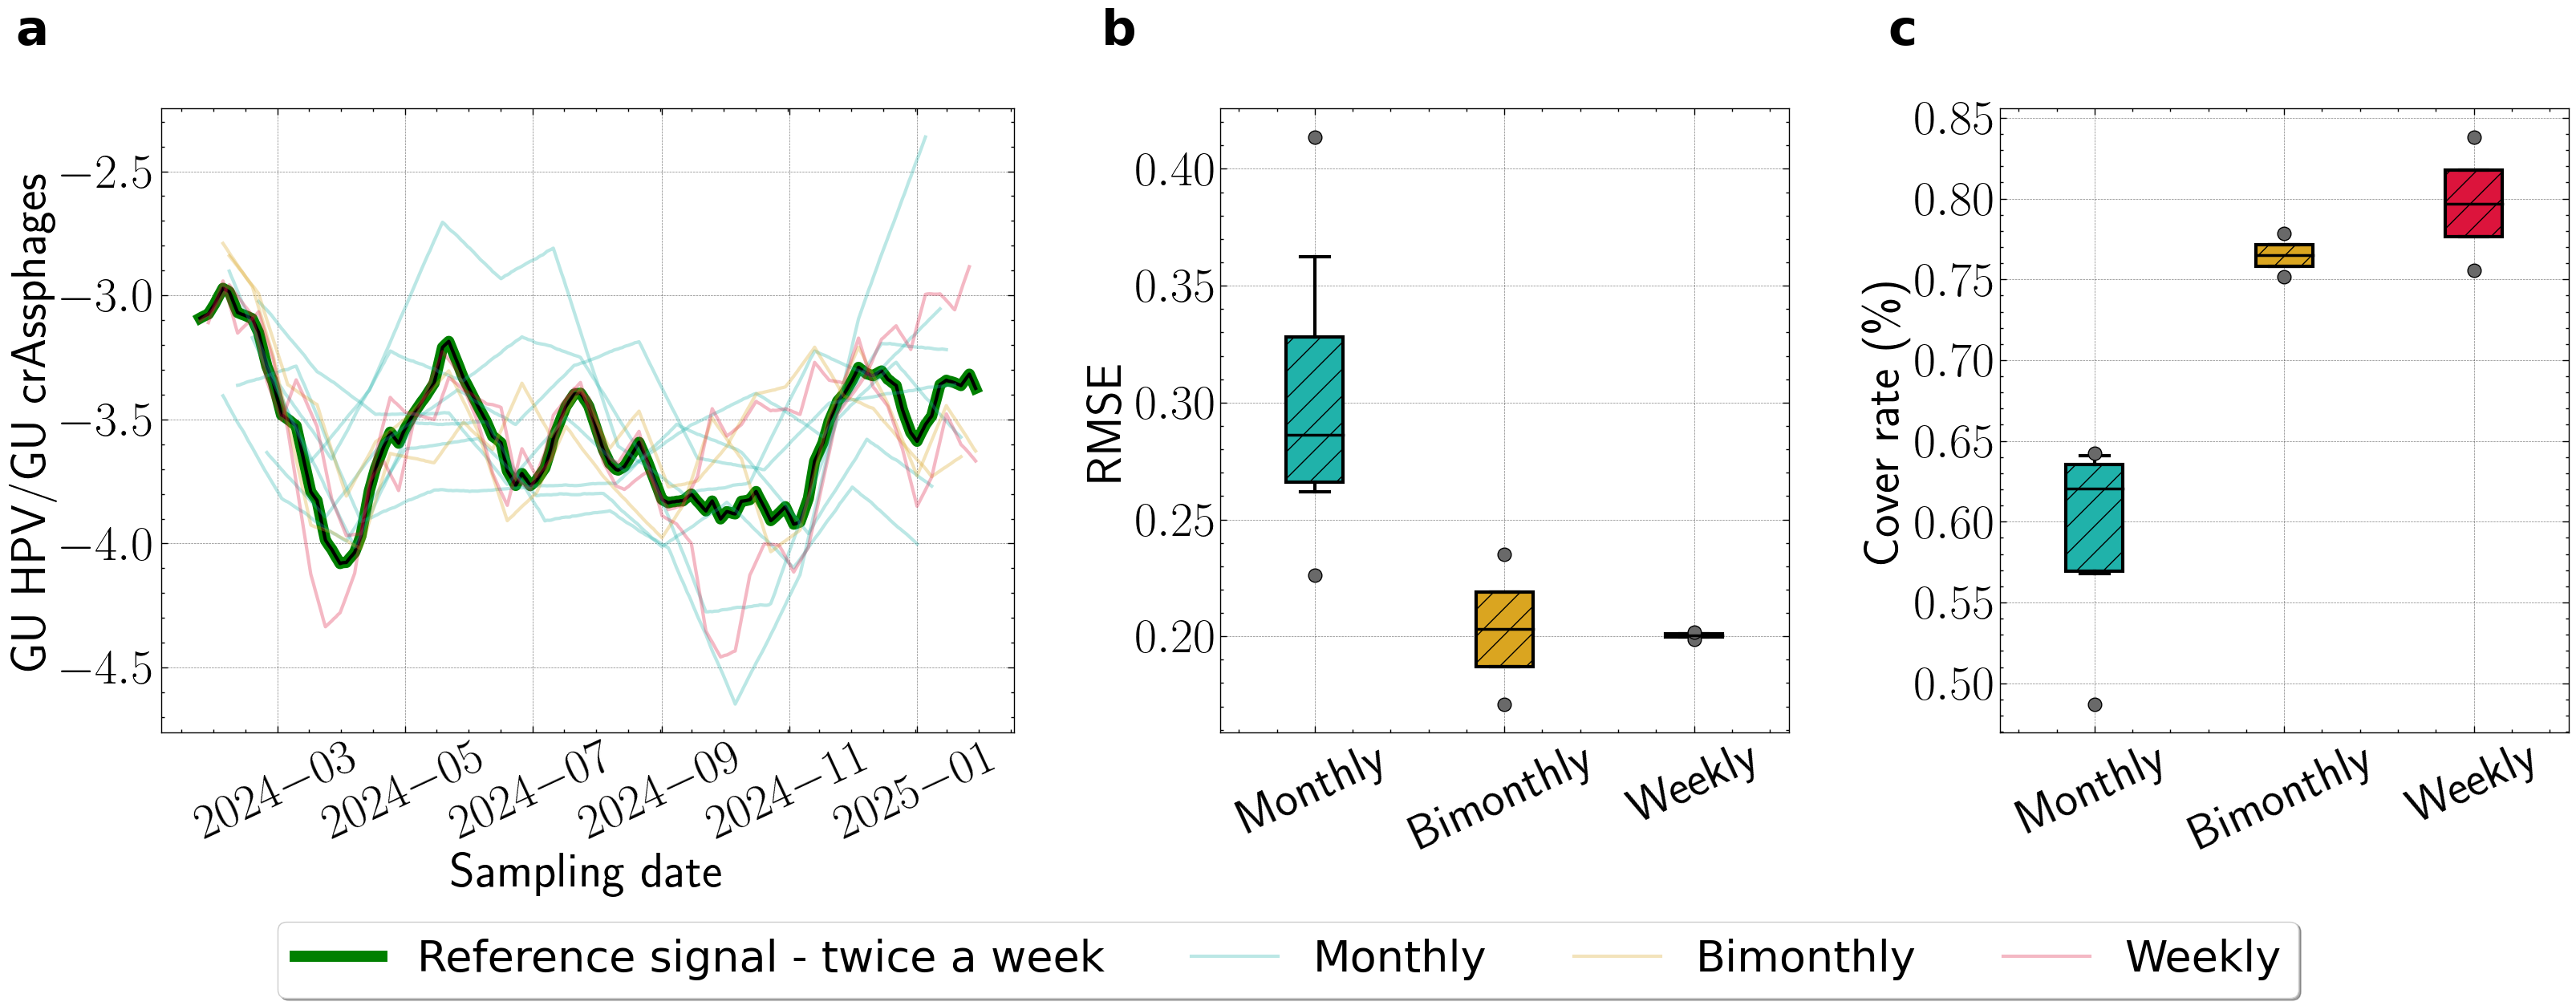

In [12]:
with plt.style.context(['science', 'notebook', 'grid']):

    ratio_factor = 1.1#0.875
    KEY_SIZE = int(40 * ratio_factor)
    LABEL_SIZE = int(40 * ratio_factor)
    TICK_SIZE = int(40 * ratio_factor)
    TITLE_SIZE = int(46 * ratio_factor)
    LEGEND_SIZE = int(36 * ratio_factor)
    DATES_SIZE = 18
    figsize = (32, 10) #(28,25) #figsize = (34, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True

    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        AAABBCC
        """,
    gridspec_kw={'wspace': 0.2}
    )
    ############################################################ A ############################################################
    reference = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_crAssphages.csv', sep=";")
    reference.dateStart = pd.to_datetime(reference.dateStart)
    ax_dict['A'].plot(reference.dateStart.values, reference.muX.values, label='Reference signal - twice a week', color='green', linewidth=10, zorder=3)
    ax_dict['A'].plot(reference.dateStart.values, reference.muX.values, color='black', linewidth=3, zorder=3)

    for candidate_path in candidate_files[4:]:
        candidate = pd.read_csv(candidate_path, sep=";")
        candidate.dateStart = pd.to_datetime(candidate.dateStart)
        ax_dict['A'].plot(candidate.dateStart.values, candidate.muX.values, label='Monthly', color='lightseagreen', linewidth=3, zorder=3, alpha=.3)
    
    for candidate_path in candidate_files[2:4]:
        candidate = pd.read_csv(candidate_path, sep=";")
        candidate.dateStart = pd.to_datetime(candidate.dateStart)
        ax_dict['A'].plot(candidate.dateStart.values, candidate.muX.values, label='Bimonthly', color='goldenrod', linewidth=3, zorder=3, alpha=.3)

    for candidate_path in candidate_files[:2]:
        candidate = pd.read_csv(candidate_path, sep=";")
        candidate.dateStart = pd.to_datetime(candidate.dateStart)
        ax_dict['A'].plot(candidate.dateStart.values, candidate.muX.values, label='Weekly', color='crimson', linewidth=3, zorder=3, alpha=.3)
    
    ax_dict['A'].set_ylabel("GU HPV/GU crAssphages")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE, rotation=25)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ############################################################ B ############################################################
    boxplot_monthly = ax_dict['B'].boxplot(RMSES_monthly, 
                                       positions=[0],
                                       whis=whiskers,
                                       patch_artist=patch_artist,
                                       medianprops=medianprops,
                                       flierprops=flierprops,
                                       whiskerprops=whiskerprops,
                                       capprops=capprops,
                                       showfliers=showfliers,
                                       widths=width
                                       )

    for index, bplot in enumerate(boxplot_monthly['boxes']):
        color = 'lightseagreen'
        hatch = '/'
        legend = 'Marne Aval'
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)

    boxplot_bimonthly = ax_dict['B'].boxplot(RMSES_bimonthly, 
                                       positions=[1],
                                       whis=whiskers,
                                       patch_artist=patch_artist,
                                       medianprops=medianprops,
                                       flierprops=flierprops,
                                       whiskerprops=whiskerprops,
                                       capprops=capprops,
                                       showfliers=showfliers,
                                       widths=width
                                       )

    for index, bplot in enumerate(boxplot_bimonthly['boxes']):
        color = 'goldenrod'
        hatch = '/'
        legend = 'Marne Aval'
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)

    boxplot_weekly = ax_dict['B'].boxplot(RMSES_weekly, 
                                       positions=[2],
                                       whis=whiskers,
                                       patch_artist=patch_artist,
                                       medianprops=medianprops,
                                       flierprops=flierprops,
                                       whiskerprops=whiskerprops,
                                       capprops=capprops,
                                       showfliers=showfliers,
                                       widths=width
                                       )

    for index, bplot in enumerate(boxplot_weekly['boxes']):
        color = 'crimson'
        hatch = '/'
        legend = 'Marne Aval'
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)
        
    ax_dict['B'].set_ylabel("RMSE")
    ax_dict['B'].set_xticks(np.arange(len(box_labels)))
    ax_dict['B'].set_xticklabels(box_labels)
    ax_dict['B'].tick_params(axis='x', labelsize=TICK_SIZE, rotation=25)
    ############################################################ C ############################################################
    boxplot_monthly = ax_dict['C'].boxplot(CR_monthly, 
                                       positions=[0],
                                       whis=whiskers,
                                       patch_artist=patch_artist,
                                       medianprops=medianprops,
                                       flierprops=flierprops,
                                       whiskerprops=whiskerprops,
                                       capprops=capprops,
                                       showfliers=showfliers,
                                       widths=width
                                       )

    for index, bplot in enumerate(boxplot_monthly['boxes']):
        color = 'lightseagreen'
        hatch = '/'
        legend = 'Marne Aval'
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)

    boxplot_bimonthly = ax_dict['C'].boxplot(CR_bimonthly, 
                                       positions=[1],
                                       whis=whiskers,
                                       patch_artist=patch_artist,
                                       medianprops=medianprops,
                                       flierprops=flierprops,
                                       whiskerprops=whiskerprops,
                                       capprops=capprops,
                                       showfliers=showfliers,
                                       widths=width
                                       )

    for index, bplot in enumerate(boxplot_bimonthly['boxes']):
        color = 'goldenrod'
        hatch = '/'
        legend = 'Marne Aval'
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)

    boxplot_weekly = ax_dict['C'].boxplot(CR_weekly, 
                                       positions=[2],
                                       whis=whiskers,
                                       patch_artist=patch_artist,
                                       medianprops=medianprops,
                                       flierprops=flierprops,
                                       whiskerprops=whiskerprops,
                                       capprops=capprops,
                                       showfliers=showfliers,
                                       widths=width
                                       )

    for index, bplot in enumerate(boxplot_weekly['boxes']):
        color = 'crimson'
        hatch = '/'
        legend = 'Marne Aval'
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)

    ax_dict['C'].set_ylabel("Cover rate (\%)")
    ax_dict['C'].set_xticks(np.arange(len(box_labels)))
    ax_dict['C'].set_xticklabels(box_labels)
    ax_dict['C'].tick_params(axis='x', labelsize=TICK_SIZE, rotation=25)

    # Legends
    # Display subplot keys
    plt.rcParams['text.usetex'] = False
    fig.canvas.draw()

    # Function to align text with the ylabel of a specific axis
    def align_text_with_ylabel(ax, text, fig):
        ylabel = ax.yaxis.label
        bbox = ylabel.get_window_extent()
        bbox_fig = fig.transFigure.inverted().transform(bbox)
        ylabel_center_fig_x = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ylabel_center_fig_y = (bbox_fig[0, 1] + bbox_fig[1, 1]) / 2
        fig.text(ylabel_center_fig_x, ylabel_center_fig_y + 0.48, text.lower(), ha='center', va='center', size=KEY_SIZE, weight='bold')

    # Align text with the ylabels for each subplot
    for n, (key, ax) in enumerate(ax_dict.items()):
        align_text_with_ylabel(ax, key, fig)
    
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()

    seen = set()
    unique_elements = []
    unique_positions = []
    
    for i, elem in enumerate(l1):
        if elem not in seen:
            seen.add(elem)
            unique_elements.append(elem)
            unique_positions.append(i) 

    l1 = unique_elements
    h1 = np.array(h1)[unique_positions].tolist()
    
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=4)
    plt.savefig('../outputs/figs/Subsampling_impact.pdf', bbox_inches = 'tight')